In [2]:
!nvidia-smi

Tue Oct 29 18:05:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.02              Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   56C    P8             22W /   80W |    1201MiB /  16384MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!conda info --envs

# conda environments:
#
base                     /home/dickoah/miniconda3
b_lora                   /home/dickoah/miniconda3/envs/b_lora
nfinite_genai         *  /home/dickoah/miniconda3/envs/nfinite_genai



In [4]:
import torch
from blora_utils import BLOCKS, filter_lora, scale_lora

from diffusers import (
    AutoencoderKL, 
    AutoPipelineForText2Image, 
    TCDScheduler
)
from diffusers.utils import make_image_grid

import numpy as np

import torch


2024-10-29 18:05:53.257795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 18:05:53.395116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730221553.451212   59694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730221553.469200   59694 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 18:05:53.601884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Handling of the generation the content

In [5]:
def load_b_lora_to_unet(pipe, 
                        content_lora_model_id: str = '', 
                        style_lora_model_id: str = '', 
                        content_alpha: float = 1.,
                        style_alpha: float = 1.) -> None:
    try:
        # Get Content B-LoRA SD
        if content_lora_model_id:
            content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
            content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
            content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
        else:
            content_B_LoRA = {}

        # Get Style B-LoRA SD
        if style_lora_model_id:
            style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
            style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
            style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
        else:
            style_B_LoRA = {}

        # Merge B-LoRAs SD
        res_lora = {**content_B_LoRA, **style_B_LoRA}

        # Load
        pipe.load_lora_into_unet(res_lora, None, pipe.unet)
    except Exception as e:
        raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("device:", device)

model_id_or_path = "stabilityai/stable-diffusion-xl-base-1.0" #"SG161222/RealVisXL_V5.0_Lightning" #stabilityai/stable-diffusion-xl-base-1.0 #
vae_id_or_path = "madebyollin/sdxl-vae-fp16-fix"

vae = AutoencoderKL.from_pretrained(vae_id_or_path, torch_dtype=torch.float16)

pipe_tex2img = AutoPipelineForText2Image.from_pretrained(model_id_or_path,
                                                              vae=vae,
                                                              torch_dtype=torch.float16,
                                                            )              

# Setting up of others parameters
pipe_tex2img.enable_xformers_memory_efficient_attention()
pipe_tex2img = pipe_tex2img.to(device)

# Update of the scheduler
pipe_tex2img.scheduler = TCDScheduler.from_config(pipe_tex2img.scheduler.config)

device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to TCDScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [7]:
content_B_LoRA_path = ""
style_B_LoRA_path = "data/b-lora/Dordogne/pytorch_lora_weights.safetensors" #"data/b-lora/Dordogne/pytorch_lora_weights.safetensors" # "data/b-lora/Dordogne/checkpoint-500/pytorch_lora_weights.safetensors" #
content_alpha, style_alpha = 1, 1.1
lora_trigger_word = "[dordogne]"

In [8]:
load_b_lora_to_unet(pipe_tex2img, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

seed: 42
prompt:  The image shows a chair in a living room in style [dordogne] with a very large rug on the floor, windows, a cupboard with books and a photo frame on top, a window with a curtain, and a wall in the background, plant in pot, painting on wall, stright-lines.


  0%|          | 0/20 [00:00<?, ?it/s]

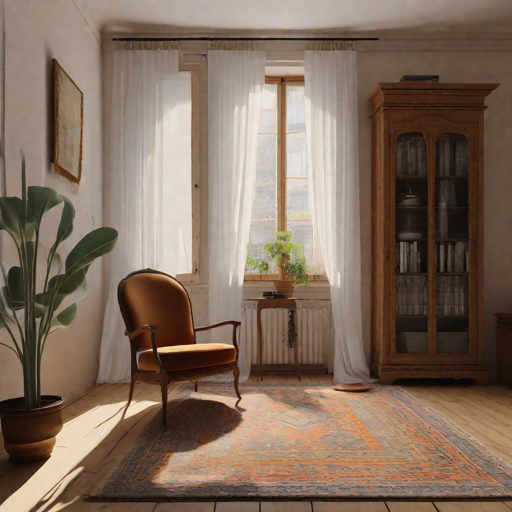

In [9]:
seed = 42 # torch.randint(0, 1000000, (1,)).item()
generator = torch.Generator(device=device).manual_seed(seed)
print(f"seed: {seed}")

# batch size
N = 1
steps = 20
guidance_scale=7

# prompt instanciation
prompt = f'The image shows a chair in a living room in style {lora_trigger_word} with a very large rug on the floor, windows, a cupboard with books and a photo frame on top, a window with a curtain, and a wall in the background, plant in pot, painting on wall, stright-lines.'
print("prompt: ", prompt)

# creation of the image(s)
images_output = pipe_tex2img(prompt=prompt, 
                                  negative_prompt=None,
                                  num_inference_steps=steps,
                                  num_images_per_prompt=N,
                                  guidance_scale=guidance_scale,
                                  generator=generator).images

# save of the image
images_output[0].save(f'blora_result_without_negative_prompt.png', "PNG")

make_image_grid(images_output, rows=1, cols=N, resize=512)

In [ ]:
# creation of the image(s)
images_output = pipe_tex2img(prompt=prompt, 
                                  negative_prompt="",
                                  num_inference_steps=steps,
                                  num_images_per_prompt=N,
                                  guidance_scale=guidance_scale,
                                  generator=generator).images

images_output[0].save(f'blora_result_with_empty_negative_prompt.png', "PNG")

make_image_grid(images_output, rows=1, cols=N, resize=512)